In [1]:
import os
import sys
os.environ['OMP_NUM_THREADS'] = '1'
sys.path.append(os.getcwd()+"/..")
import lasagne
import theano.tensor as T
import theano
from tasks import check
from scripts import manifold
from lasagne import layers as L

from lasagnekit.misc.plot_weights import dispims_color, tile_raster_images
%matplotlib inline
import matplotlib.pyplot as plt
from skimage.io import imsave

from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.manifold import TSNE
from image_scatter import image_scatter
from tqdm import tqdm

%matplotlib inline
import matplotlib.pyplot as plt
from lasagnekit.misc.plot_weights import tile_raster_images
import numpy as np

from helpers import salt_and_pepper
def sample(x):
    return (np.random.uniform(size=x.shape) <= x).astype(np.float32)


def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, max(len(inputs) - batchsize + 1, len(inputs)), batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

Couldn't import dot_parser, loading of dot files will not be possible.


## load model

In [3]:
v = check(
    what="notebook", 
    filename="../training/chinese/chinese1/model.pkl",
    force_w=28,
    force_h=28,
    dataset="digits"
)

Loading data...


INFO:tasks:Loading data...


Loading the model...


INFO:tasks:Loading the model...


(None, 1, 28, 28)
Compiling the model...


INFO:tasks:Compiling the model...


{'patience_stat': 'avg_loss_train_fix', 'epsilon': 1e-08, 'max_nb_epochs': 100000, 'batch_size': 128, 'initial_lr': 0.1, 'patience_nb_epochs': 800, 'lr_decay_method': 'none', 'beta2': 0.95, 'beta1': 0.95, 'min_nb_epochs': 100000, 'lr_decay': 0, 'momentum': 0.9, 'algo': u'adadelta'}
{'seed': 2}


In [4]:
capsule, data, layers, w, h, c = v

In [5]:
X = T.tensor4()
encode = theano.function([X], L.get_output(layers['hid1'], X))

## viz features

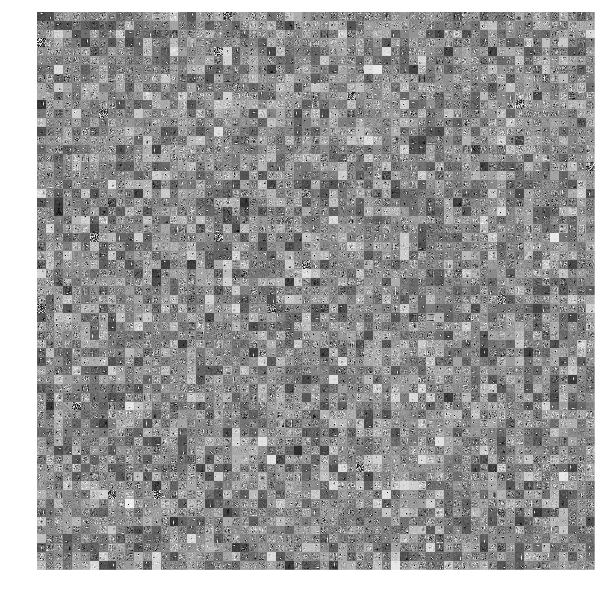

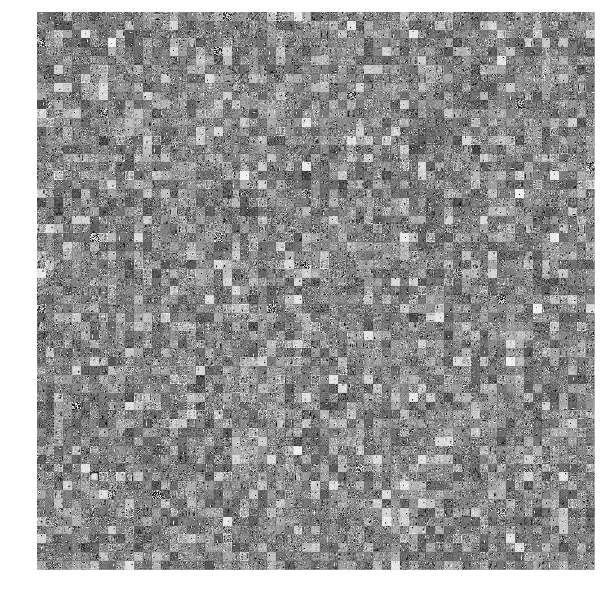

In [6]:
for name, layer in layers.items():
    if hasattr(layer, "W"):
        W = layer.W.get_value()
        if len(W.shape)==2:
            nbpixels = c*w*h
            if W.shape[0] == nbpixels:
                W = W.T
            a, b = w, h
        else:
            W = W.reshape((W.shape[0]*W.shape[1], W.shape[2], W.shape[3]))
            a, b = W.shape[1:]
        fig = plt.figure(figsize=(10, 10))
        s = int(np.sqrt(W.shape[0]))
        plt.axis('off')
        img=tile_raster_images(W, (a, b), (s, s))
        plt.imshow(img, cmap="gray", interpolation='none')
        plt.show()

In [72]:
mnist = MNIST()
mnist.load()
X_transf_orig = mnist.X.reshape((mnist.X.shape[0], c, w, h))
y_transf_orig = mnist.y

## iterative refinement

In [84]:
seed = 42
np.random.seed(seed)
N = 200

s = np.random.uniform(0, 1, size=(N, c, w, h))
s = X_transf_orig[y_transf_orig==8][0:N]

s = s.astype(np.float32)
samples = []
samples.append(s.copy()[None, :, :, :, :])
nb_iter = 100
loss = []
for i in tqdm(range(nb_iter)):
    sprev = s  
    #s = s > 0.6
    #s = s + 0.1 * (capsule.reconstruct(s) - s)
    s = s +  0.1 * (capsule.reconstruct(s) - s)
    s = s.astype(np.float32)
    samples.append(s.copy()[None, :, :, :, :])
    #s = np.random.binomial(n=1, p=s, size=s.shape).astype('float32')# binarize by sampling
    #s = s > 0.5
    score = np.abs(s - sprev).sum()
    loss.append(score)
samples = np.concatenate(samples, axis=0)
print(samples.shape)
print(loss)

(101, 200, 1, 28, 28)
[547.51038, 526.74463, 507.67499, 490.06924, 473.72443, 458.49777, 444.27429, 430.96509, 418.49478, 406.81937, 395.90277, 385.64612, 375.9213, 366.67386, 357.80176, 349.26736, 341.05783, 333.0791, 325.34058, 317.80399, 310.43033, 303.14432, 295.9288, 288.7648, 281.63812, 274.61761, 267.70148, 260.86484, 254.09636, 247.41241, 240.80525, 234.3073, 227.95103, 221.79076, 215.81607, 209.98685, 204.31544, 198.78522, 193.416, 188.19983, 183.14224, 178.25267, 173.56418, 169.07802, 164.78447, 160.66647, 156.71268, 152.9128, 149.22113, 145.63754, 142.14735, 138.74066, 135.41234, 132.15932, 129.01028, 125.96127, 123.01608, 120.18604, 117.46568, 114.86383, 112.36536, 109.97987, 107.68042, 105.44559, 103.27908, 101.16228, 99.101395, 97.095306, 95.144417, 93.228508, 91.347664, 89.505043, 87.700455, 85.918816, 84.160637, 82.445801, 80.769661, 79.149986, 77.595398, 76.105583, 74.679886, 73.326439, 72.037842, 70.809013, 69.639282, 68.514923, 67.436714, 66.399765, 65.383484, 64.382

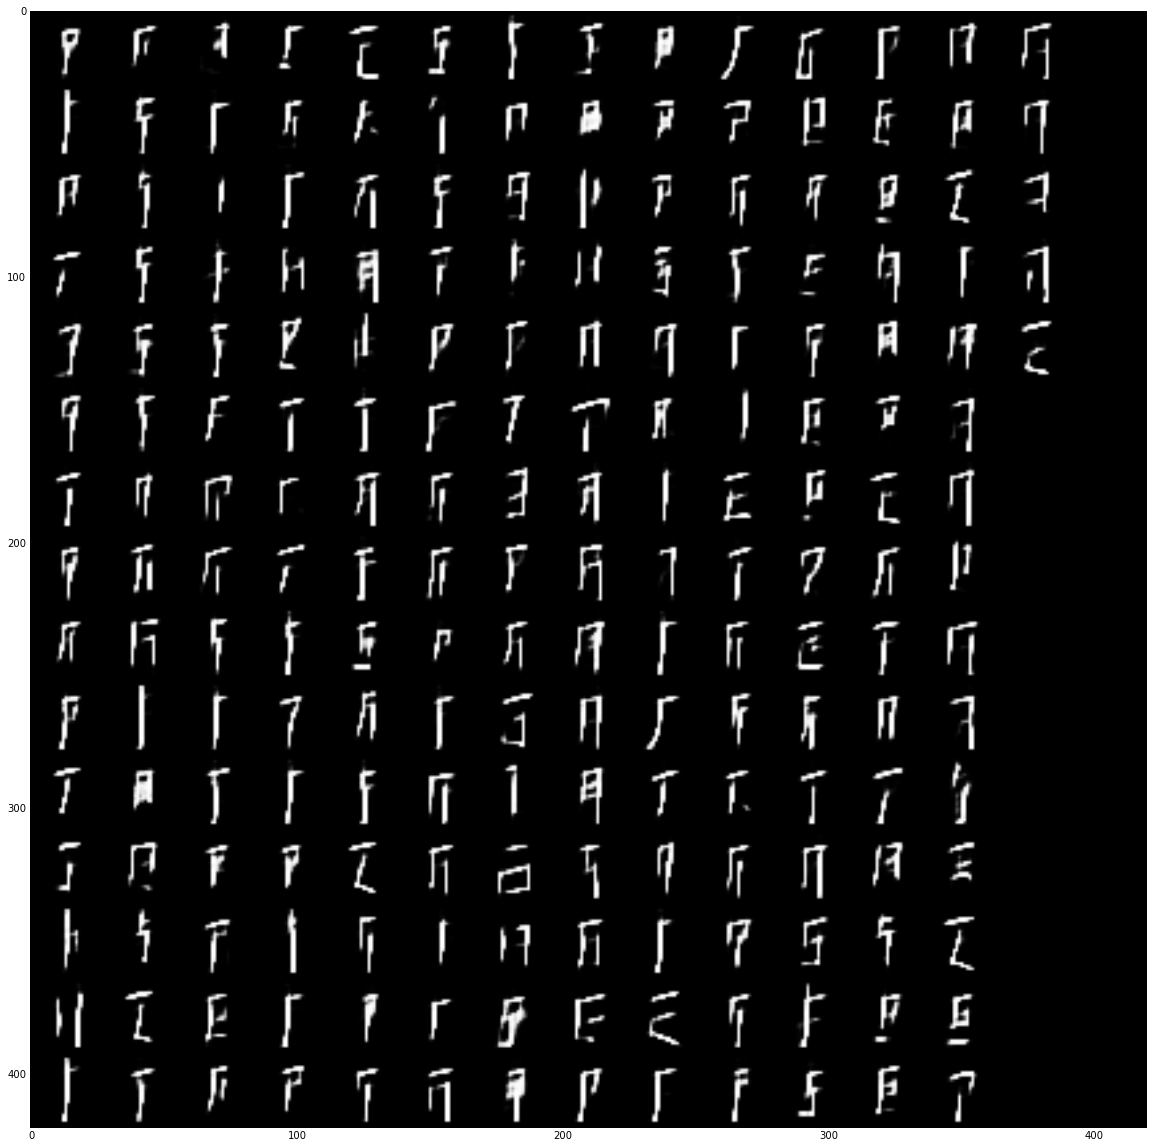

In [85]:
s = samples[-1]
s = s * np.ones((1, 3, 1, 1))
s = s.transpose((0, 2, 3, 1))
fig = plt.figure(figsize=(20, 20))
img = dispims_color(s)
plt.imshow(img)

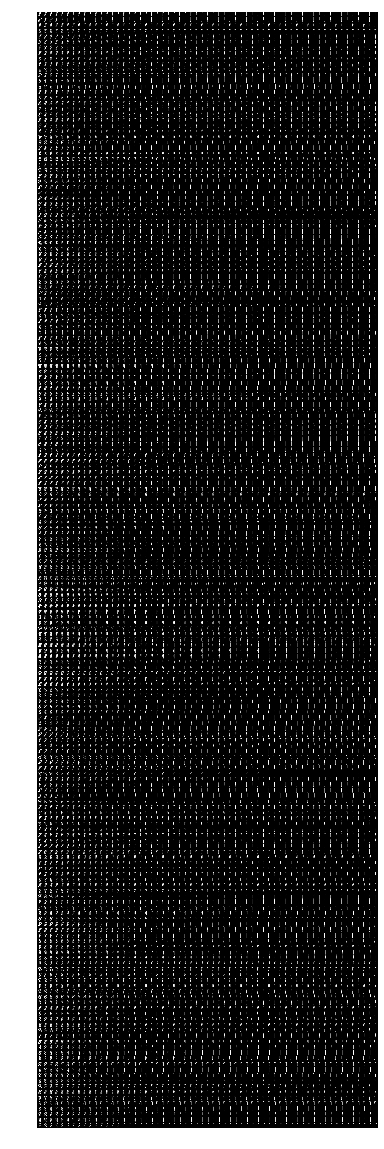

In [76]:
fig = plt.figure(figsize=(20, 20))
sw, sh = samples.shape[0:2]
samples_ = samples.copy()
samples_ = samples_.reshape((sw*sh, c, w, h))
samples_ = samples_.transpose((0, 2, 3, 1))
samples_ = samples_ * np.ones((1, 1, 1, 3))
img = dispims_color(samples_, shape=(sw, sh))
imsave('out.png', img)
plt.imshow(img)
plt.axis('off')
plt.show()

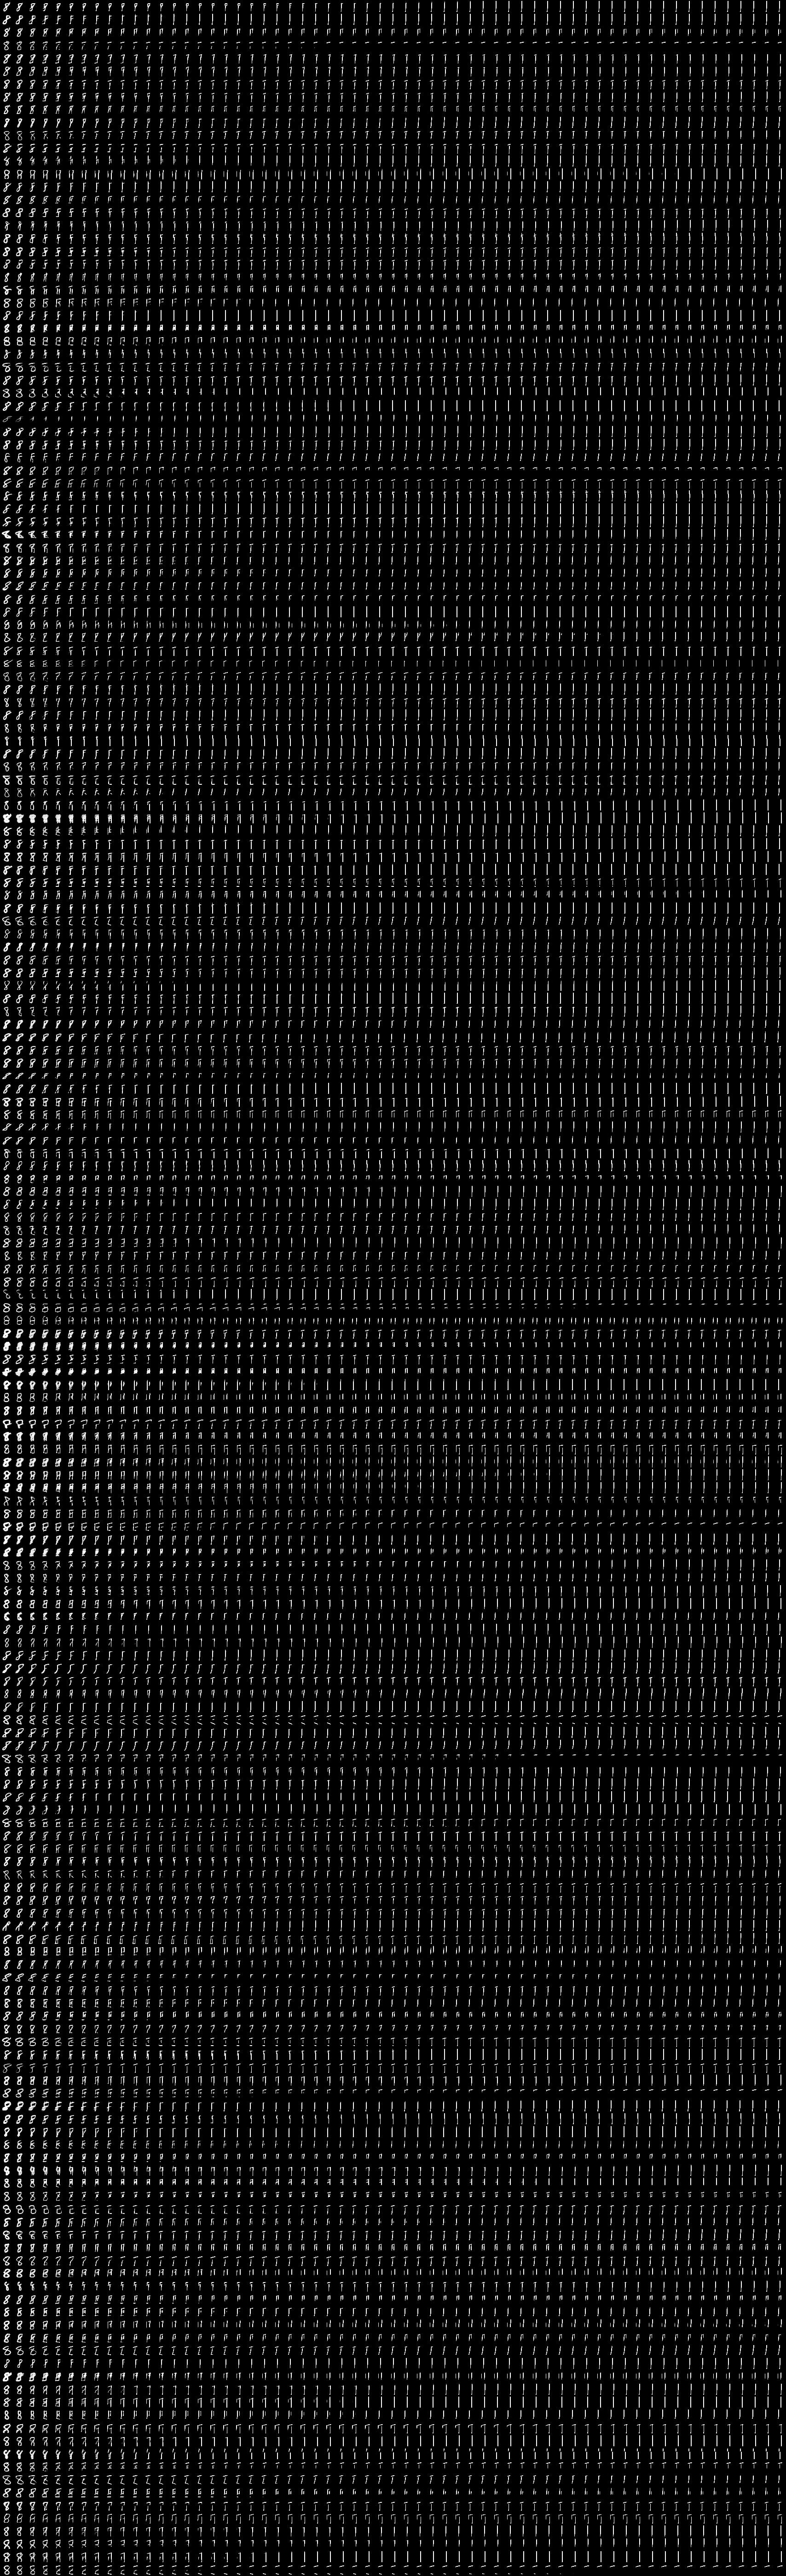

In [77]:
Image('out.png')

In [59]:
hid = []
d = []
for i in range(10):
    d.append(capsule.preprocess(data.X).transpose((0, 2 ,3 , 1))  * np.ones((1, 1, 1, 3)))
    hid.append(encode(capsule.preprocess(data.X)))

d = np.concatenate(d, axis=0)
hid = np.concatenate(hid, axis=0)

In [ ]:
#mf = IncrementalPCA(n_components=2, batch_size=1024)
mf = PCA(n_components=2)
#mf = TSNE(n_components=2, verbose=1)
h2d = mf.fit_transform(hid)

In [ ]:
mf = PCA(n_components=2)
#mf = IncrementalPCA(n_components=2, batch_size=1024)
#mf = TSNE(n_components=2, verbose=1)
d2d = mf.fit_transform(d.reshape(d.shape[0], -1))

In [ ]:
img = image_scatter(h2d, d, 80)
imsave('out_scatter.png', img)
plt.imshow(img, cmap='gray')
plt.show()

In [ ]:
img = image_scatter(d2d, d, 80)
imsave('out_scatter_data.png', img)
plt.imshow(img, cmap='gray')
plt.show()

## transferability

In [10]:
from lasagnekit.datasets.mnist import MNIST

In [63]:
Digit = 8
mnist = MNIST()
mnist.load()


X_transf_orig = mnist.X.reshape((mnist.X.shape[0], c, w, h))
X_transf_orig = X_transf_orig[mnist.y==Digit]
X_transf_orig = X_transf_orig[0:500]
#X_transf_orig = np.random.uniform(size=(500, c, w, h)).astype(np.float32)


X_transf_rec = X_transf_orig.copy().astype(np.float32)
X_transf_rec = X_transf_rec
imgs = []
for i in tqdm(range(100)):
    X_transf_rec = X_transf_rec + 0.1 * (capsule.reconstruct(X_transf_rec) - X_transf_rec)
    imgs.append(X_transf_rec.copy())
    #print(((X_transf_rec - capsule.reconstruct(X_transf_rec))**2).sum(axis=(1, 2, 3)).mean())
    
from scripts import imgtovideo
x = []
for img in imgs:
    img = img * np.ones((1, 3, 1, 1))
    img = img.transpose((0, 2, 3, 1))
    x.append(dispims_color(img))
imgtovideo.imgs_to_video(x, out='/home/mcherti/out{}.mp4'.format(Digit), verbose=1)

ffmpeg -framerate 20 -i img%08d.png -c:v libx264 -r 20 -pix_fmt yuv420p /home/mcherti/out8.mp4


In [64]:
X_transf = X_transf_orig.transpose((0, 2, 3, 1))
X_transf = X_transf * np.ones((1, 1, 1, 3))

X_transf_rec = X_transf_rec.transpose((0, 2, 3, 1))
X_transf_rec = X_transf_rec * np.ones((1, 1, 1, 3))

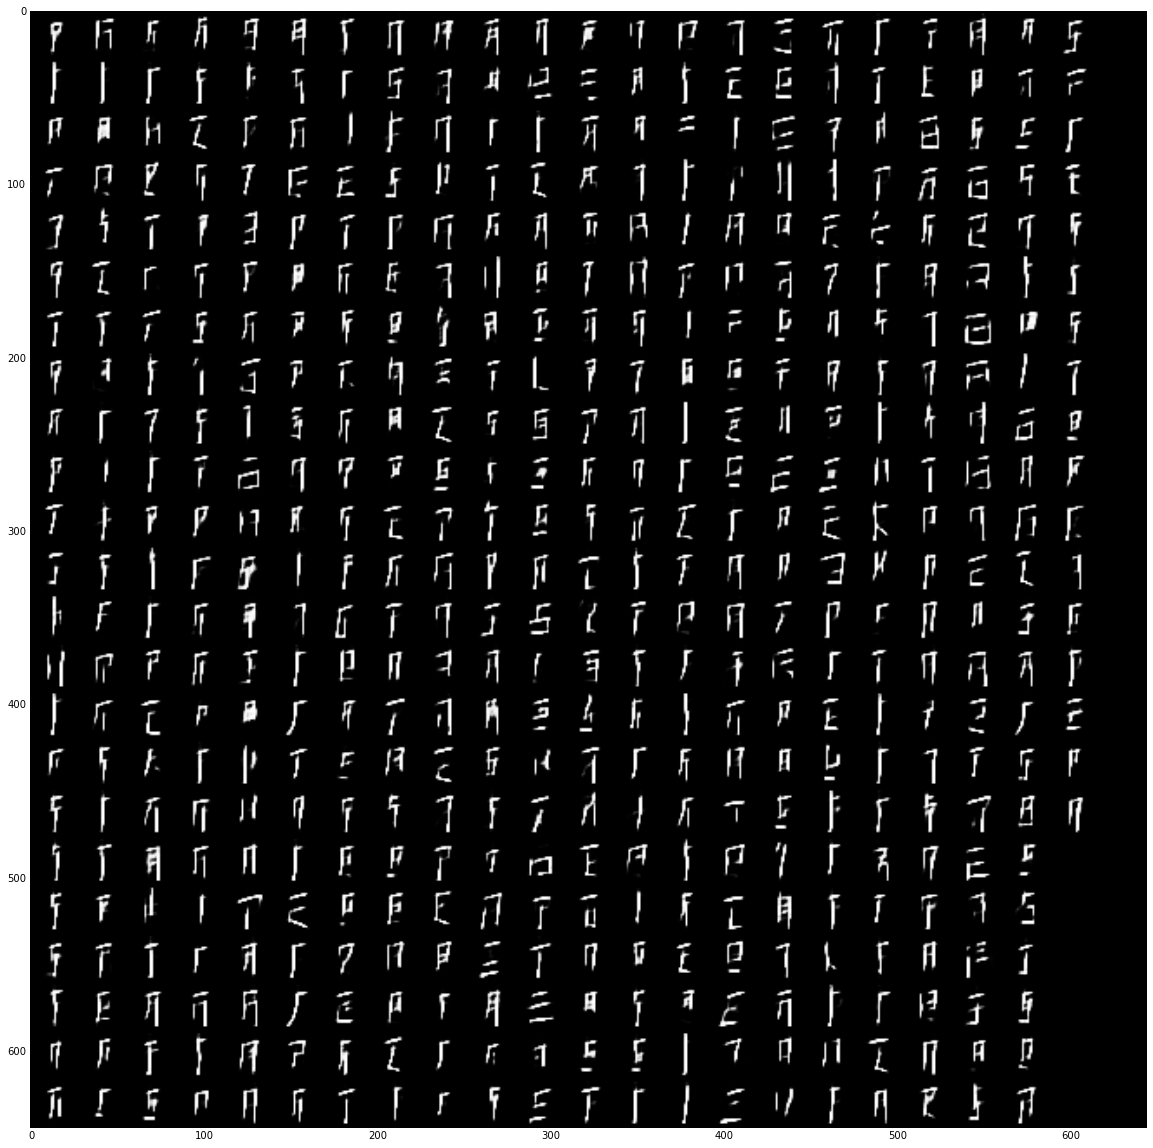

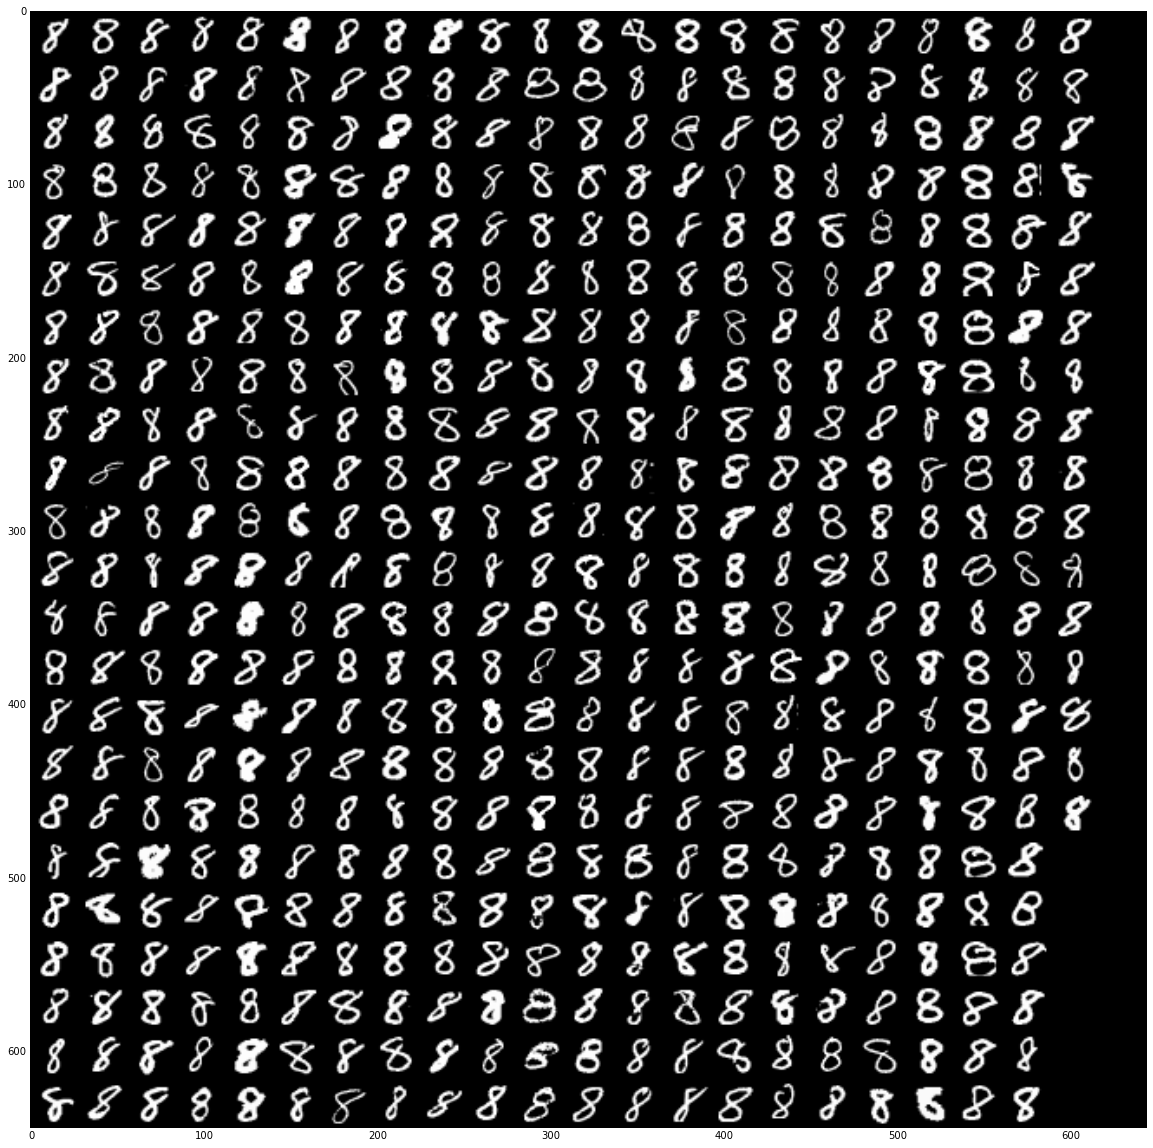

In [65]:
fig = plt.figure(figsize=(20, 20))
img = dispims_color(X_transf_rec[0:500])
plt.imshow(img, cmap='gray')
plt.show()
fig = plt.figure(figsize=(20, 20))
img = dispims_color(X_transf[0:500])
plt.imshow(img, cmap='gray')
plt.show()